In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')

In [3]:
# Lectura de los datos
data = pd.read_csv('../data/raw/Country-data.csv', index_col=['country'])
data.sample(5, random_state=777)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Bangladesh,49.40,16.00,3.52,21.80,2440,7.14,70.40,2.33,758
Bhutan,42.70,42.50,5.20,70.70,6420,5.99,72.10,2.38,2180
Malta,6.80,153.00,8.65,154.00,28300,3.83,80.30,1.36,21100
Tonga,17.40,12.40,5.07,60.30,4980,3.68,69.90,3.91,3550
Italy,4.00,25.20,9.53,27.20,36200,0.32,81.70,1.46,35800


In [4]:
# Función para capturar los tipos de variables
continuous, categoricals, discretes, temporaries = capture_variables(data=data)

		Tipos de variables
Hay 9 variables continuas
Hay 0 variables discretas
Hay 0 variables temporales
Hay 0 variables categóricas


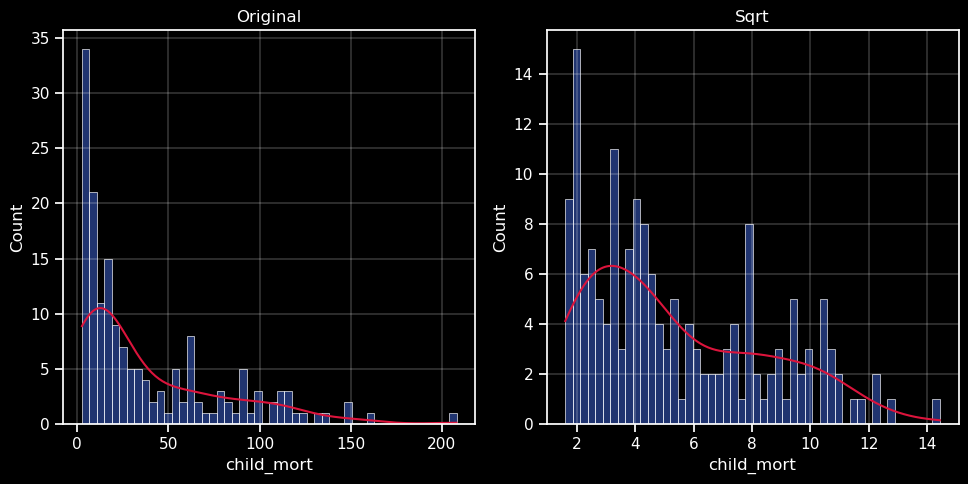

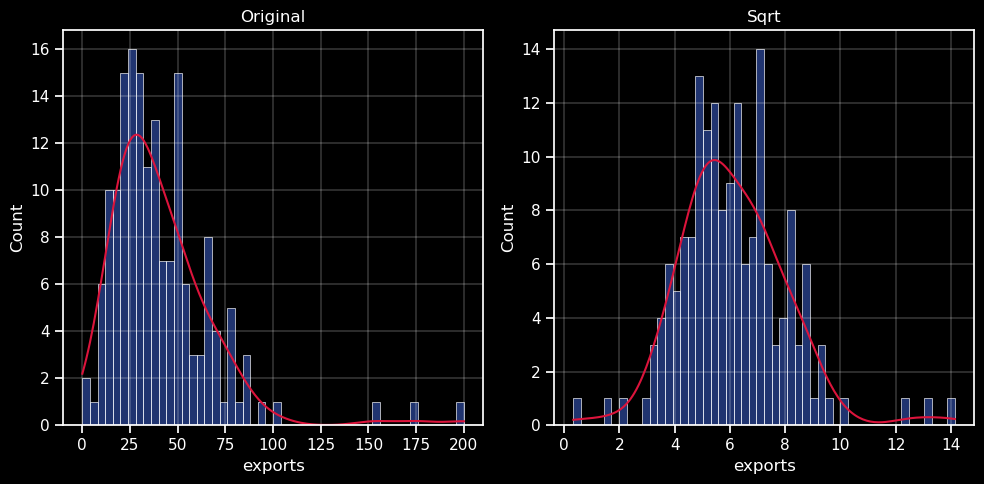

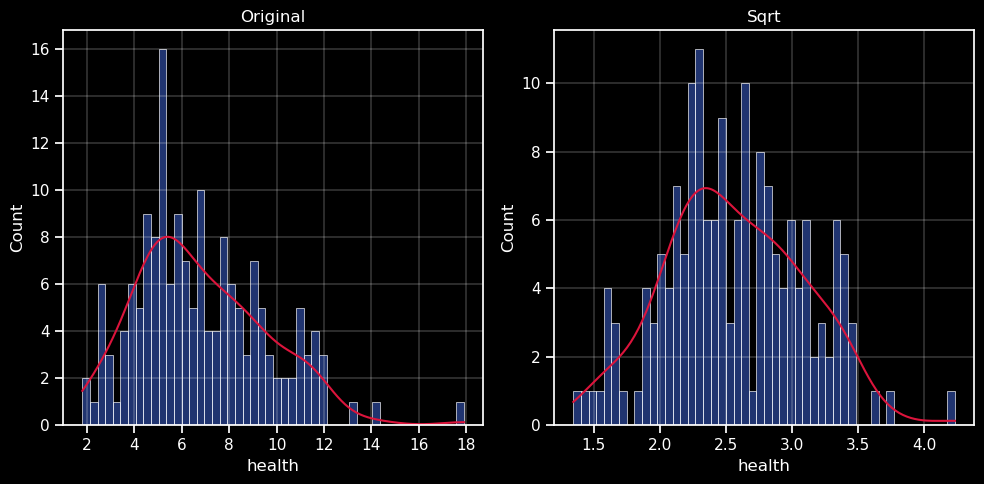

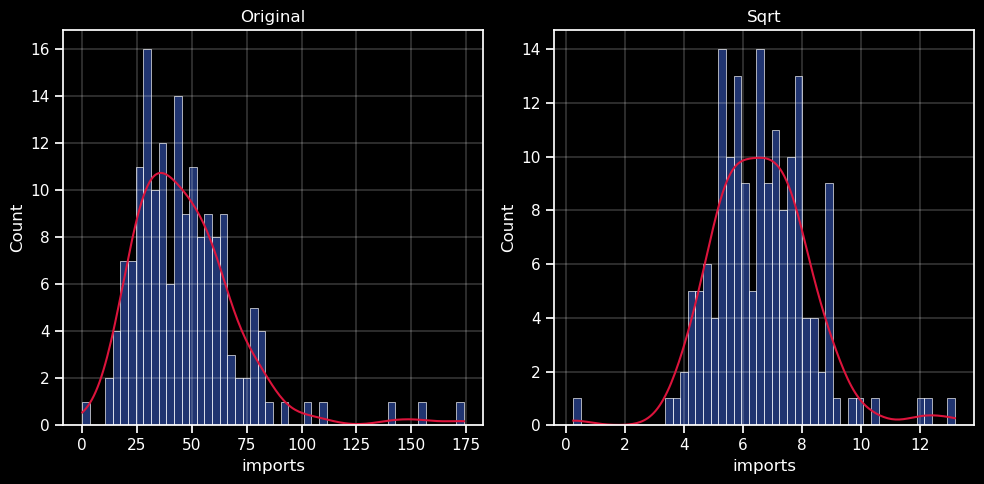

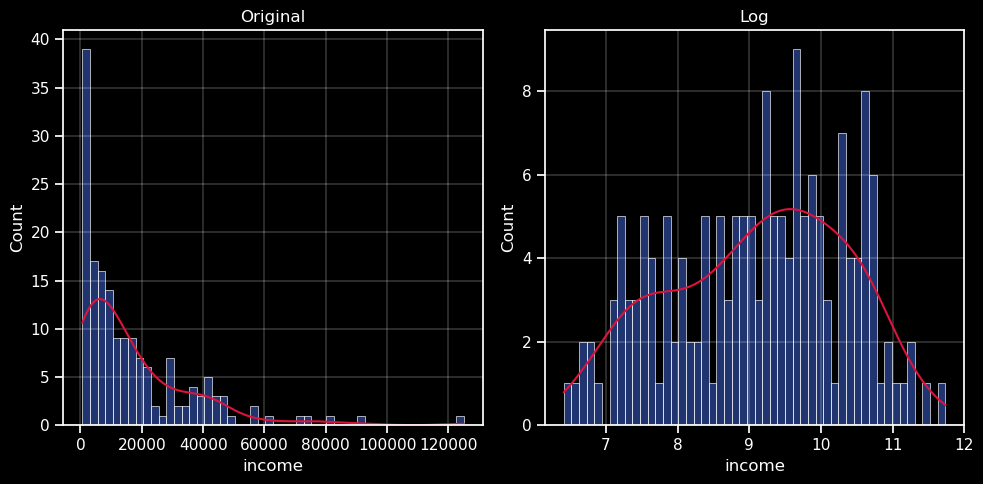

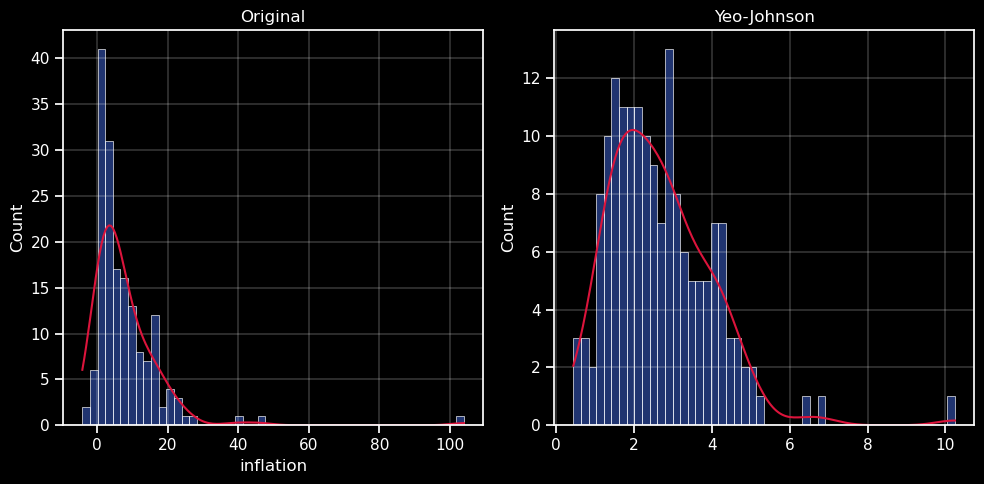

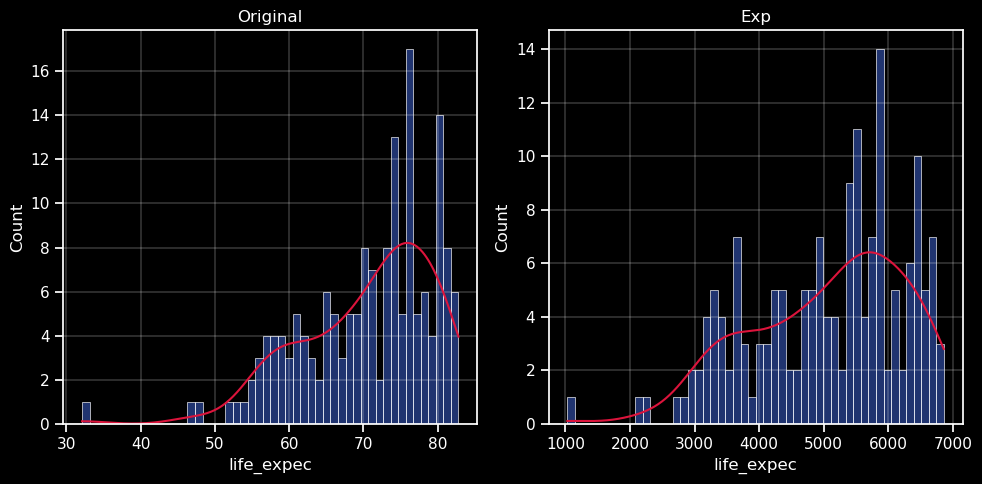

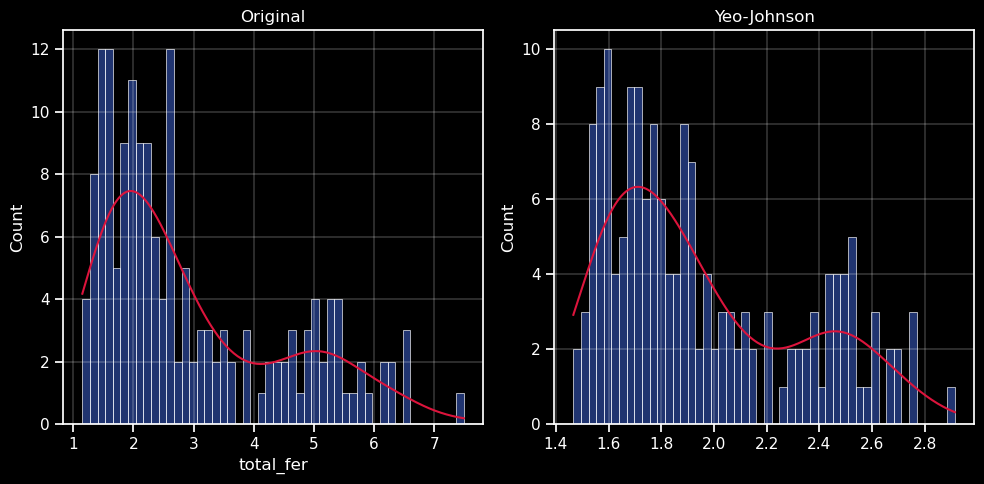

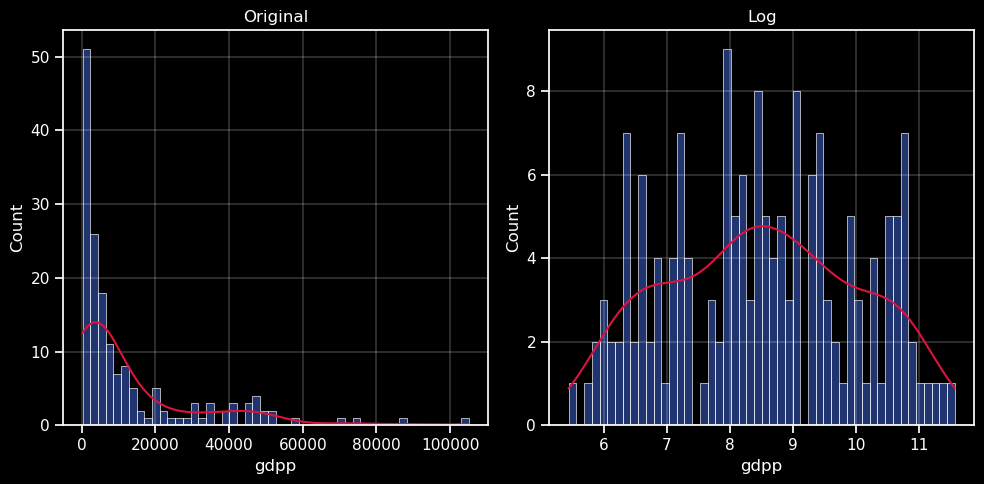

In [5]:
transformaciones = gaussian_transformation(data=data, variables=continuous)

graficar_transformaciones(data=data, 
                          continuous=continuous, 
                          transformacion=transformaciones)

In [6]:
correlacionados = ['life_expec', 'gdpp', 'total_fer']

sqrt = [variable for variable, transformacion in transformaciones.items() if transformacion == 'Sqrt' and variable not in correlacionados]
log = [variable for variable, transformacion in transformaciones.items() if transformacion == 'Log' and variable not in correlacionados]
exp = [variable for variable, transformacion in transformaciones.items() if transformacion == 'Exp' and variable not in correlacionados]
yeo_johnson = [variable for variable, transformacion in transformaciones.items() if transformacion == 'Yeo-Johnson' and variable not in correlacionados]

In [7]:
# Pipeline
from sklearn.pipeline import Pipeline

# Ingeniería de variables
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import Normalizer

# Selección de variables
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures


pipe = Pipeline([    
    # === FILTRO BÁSICO ===
    # === Cuasi-constantes ===
    ('constant', DropConstantFeatures(tol=0.998)),
    
    # === Duplicados ===
    ('duplicated', DropDuplicateFeatures()),
    
    # === Correlacionados ===
    ('correlation', DropCorrelatedFeatures(method='pearson', threshold=0.8)),
    
    # === OUTLIERS ===
    # === Censurar outliers ===
    ('outliers', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
    
    # === NORMALIDAD ===
    ('sqrt', PowerTransformer(variables=sqrt, exp=1/2)),
    ('log', LogTransformer(variables=log)),
    ('yeo-johhson', YeoJohnsonTransformer(yeo_johnson)),
    
    # === NORMALIZACIÓN ===
    ('normalizer', Normalizer(norm='l1')) # La norma del vector (Distancia de Manhattan)
])

In [8]:
# 1. Ajustemos el Pipeline con los datos de entrenamiento
pipe.fit(data)

# 2. Hacemos una transformación: trasladando los cambios del train a los otros conjuntos de datos
X = pd.DataFrame(pipe.transform(data), columns=pipe.get_feature_names_out(), index=data.index)

# Resultados de las transformaciones en la Pipeline
print(f"""\tResultados de las transformaciones
• Features constantes y cuasi-constantes: {pipe.named_steps['constant'].features_to_drop_}
• Features duplicados: {pipe.named_steps['duplicated'].features_to_drop_}
• Features correlacionados: {pipe.named_steps['correlation'].features_to_drop_}
• Features con outliers censurados: {pipe.named_steps['outliers'].variables_}""")

X

	Resultados de las transformaciones
• Features constantes y cuasi-constantes: []
• Features duplicados: set()
• Features correlacionados: {'total_fer', 'life_expec', 'gdpp'}
• Features con outliers censurados: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation']


,child_mort,exports,health,imports,income,inflation
country,,,,,,
Afghanistan,0.28,0.09,0.08,0.19,0.21,0.14
Albania,0.13,0.17,0.08,0.23,0.30,0.09
Algeria,0.15,0.17,0.06,0.16,0.27,0.20
Angola,0.24,0.18,0.04,0.15,0.19,0.20
Antigua and Barbuda,0.10,0.22,0.08,0.25,0.32,0.04
...,...,...,...,...,...,...
Vanuatu,0.17,0.22,0.07,0.23,0.25,0.06
Venezuela,0.12,0.15,0.06,0.12,0.28,0.27
Vietnam,0.12,0.22,0.07,0.23,0.21,0.15


In [10]:
import joblib

# Guardar el objeto StandardScaler en un archivo
joblib.dump(pipe['normalizer'], '../models/scaler.pkl')
X.to_csv('../data/processed/data_processed.csv', index=True)

---
---